In [14]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../")
from pathlib import Path

import pandas as pd
import geopandas as gpd
import numpy as np
import plotly.express as px
import basedosdados as bd
from shapely.wkt import loads
from shapely import ops
from shapely.ops import split

pd.options.display.max_columns = 999
pd.options.display.max_rows = 1999
pd.options.display.max_colwidth = 200

/Users/m/miniconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Observações

- Os dados utilizados nos tratamentos se encontram na pasta do [Google Drive](https://drive.google.com/drive/folders/1TQjha0aPdBLfBGek8Bl48cmdGbX_j_qC)

### Shapes

- Trem
- VLT
- Transbrasil – Linha 62
- Transolimpica - 
- Transcarioca
- Transoeste

In [3]:
### SHAPES TP RJ

query = """
SELECT 
  CASE 
    WHEN id_modal_smtr = '10' THEN "Metrô"
    WHEN id_modal_smtr = '11' THEN "Trem"
    WHEN id_modal_smtr = '12' THEN "VLT"
    WHEN id_modal_smtr = '13' THEN "Bonde"
    WHEN id_modal_smtr = '14' THEN "Plano Inclinado"
    WHEN id_modal_smtr = '20' THEN "BRT"
    WHEN id_modal_smtr = '21' THEN "BHLS"
    WHEN id_modal_smtr = '22' THEN "SPPO"
    WHEN id_modal_smtr = '23' THEN "SPPO Executivo"
    WHEN id_modal_smtr = '30' THEN "DETRO RMTJ"
    WHEN id_modal_smtr = '31' THEN "Varia conforme região"
    WHEN id_modal_smtr = '32' THEN "Varia conforme região"
    WHEN id_modal_smtr = '33' THEN "Varia conforme região"
    WHEN id_modal_smtr = '34' THEN "Varia conforme região"
    WHEN id_modal_smtr = '35' THEN "Varia conforme região"
    WHEN id_modal_smtr = '36' THEN "Varia conforme região"
    WHEN id_modal_smtr = '37' THEN "Varia conforme região"
    WHEN id_modal_smtr = '38' THEN "Varia conforme região"
    WHEN id_modal_smtr = '39' THEN "Varia conforme região"
    WHEN id_modal_smtr = '40' THEN "STPL"
    WHEN id_modal_smtr = '41' THEN "STPC"
    WHEN id_modal_smtr = '50' THEN "Barcas"
    WHEN id_modal_smtr = '60' THEN "Teleferico"
 END AS id_modal_smtr,
  * EXCEPT(
    versao,
    id_modal_smtr
    )
FROM `rj-smtr.br_rj_riodejaneiro_sigmob.shapes_geom` 
WHERE data_versao = "2022-03-10"
"""

shapes = bd.read_sql(query,billing_project_id='rj-escritorio-dev',  use_bqstorage_api=True)
shapes.to_csv('data/raw/shapes_transporte_rj_sigmob.csv', index=False)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████| 1351/1351 [01:06<00:00, 20.44rows/s]


In [36]:
shapes = gpd.read_file('data/raw/shapes_transporte_rj_sigmob.csv')

corredor_dict = {
    '62': 'TransBrasil',
    '55': 'TransOlímpica',
    '46': 'TransCarioca',
    '42A': 'TransCarioca',
    '53': 'TransOlímpica',
    '18': 'TransOeste',
    '17': 'TransOeste',
    '20': 'TransOeste',    
}

gestao_dict = {
    '62': 'Futuro',
    '55': 'Paes',
    '46': 'Paes',
    '42A': 'Paes',
    '53': 'Paes',
    '18': 'Paes',
    '17': 'Crivela',
    '20': 'Paes',    
}

shapes['corredor'] = shapes['linha_gtfs'].apply(lambda x: corredor_dict.get(x))
shapes['gestao'] = shapes['linha_gtfs'].apply(lambda x: gestao_dict.get(x))

shapes['geometry'] = shapes['shape'].apply(loads)
shapes['shape'] = shapes['shape'].apply(loads)

corredores = shapes[~shapes['corredor'].isna()].drop('shape',1).dissolve(['corredor','gestao'], as_index=False)


<AxesSubplot:>

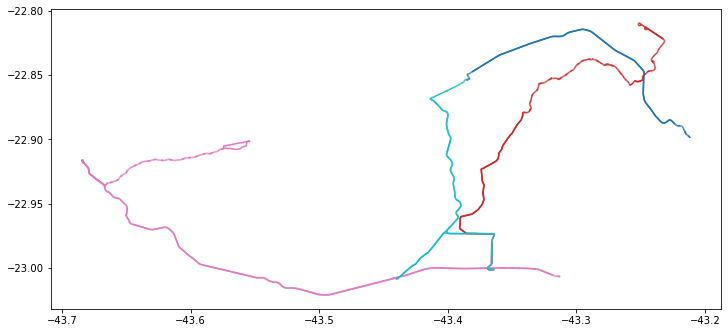

In [37]:
corredores.reset_index().plot(column = 'corredor', figsize=(12,12))

In [6]:
corredores_plot = corredores.reset_index()[['corredor', 'geometry']]
corredores_plot.to_csv('data/treated/shapes/corredores_plot.csv', index=False)
corredores.to_csv('data/treated/shapes/corredores.csv', index=False)

### shapes Metro, Trem

 - Quebra linha 4

In [338]:
outros = shapes[shapes['id_modal_smtr'].isin(['Metrô', 'Trem'])]


In [321]:
query = """
SELECT distinct stop_name, stop_lat, stop_lon
FROM `rj-smtr.br_rj_riodejaneiro_sigmob.stop_details_desaninhada` 
where modal = 'Metrô' and (stop_name = 'General Osório' or stop_name='Saens Peña')
"""

estacoes_quebra_original = bd.read_sql(query,billing_project_id='rj-escritorio-dev',  use_bqstorage_api=True)

Downloading: 100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 72.85rows/s]


In [322]:

estacoes_quebra =  estacoes_quebra_original.drop_duplicates('stop_name')
estacoes_quebra = gpd.GeoDataFrame(
    estacoes_quebra,
    geometry=gpd.points_from_xy(estacoes_quebra.stop_lon, estacoes_quebra.stop_lat),
)
estacoes_quebra['geometry'] = estacoes_quebra['geometry'].apply(lambda x: x.buffer(0.0005))

In [328]:

mask = (outros["id_modal_smtr"] == "Metrô") & (outros["linha_gtfs"] == "1")
linha_1 = outros[mask].head(1)


linha = linha_1['geometry'].values[0]
general = estacoes_quebra.head(1)['geometry'].values[0]
saens = estacoes_quebra.tail(1)['geometry'].values[0]
result = split(linha, general)

barra = linha_1.copy()
barra['linha_gtfs'][barra.index] = 'linha 4'
barra['geometry'][barra.index] = result[2]

zs = linha_1.copy()
zs['linha_gtfs'][zs.index] = 'linha 1'
zs['geometry'][zs.index] = result[0]

In [330]:
outros_final = pd.concat([barra,outros])
outros_final = pd.concat([zs,outros_final])
outros_final = outros_final.drop_duplicates('linha_gtfs').reset_index(drop=True)
outros_final = outros_final[outros_final['linha_gtfs']!='1']
outros_final['linha_gtfs'] = outros_final['linha_gtfs'].str.replace('2','linha 2')

In [336]:
outros_final.to_csv('data/treated/shapes/trem_metro.csv', index=False)


### Estações com data de abertura

- Transolimpica
- Transcarioca
- Transoeste
- Transbrasil


<AxesSubplot:>

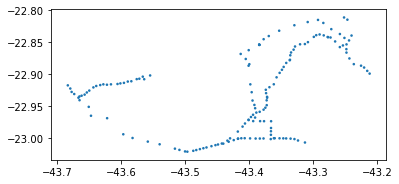

In [76]:
estacoes = pd.read_csv('data/raw/estacoes_brt_georeferenciadas.csv')
estacoes = gpd.GeoDataFrame(estacoes)

estacoes['geometry'] = estacoes['geometry'].apply(loads)
estacoes['buffer'] = estacoes['geometry'].apply(lambda x: x.buffer(0.002))
estacoes['buffer'].plot()

In [77]:
estacoes_corr = gpd.sjoin(
    corredores, gpd.GeoDataFrame(estacoes[["stop_id", "buffer"]], geometry="buffer")
).reset_index()
estacoes_final = estacoes_corr.rename(columns={'geometry':'geometry_linha'}).drop(
    columns=[
        "shape_id",
        "trip_id",
        "route_id",
        "start_pt",
        "end_pt",
        "data_versao",
        "index_right",
    ]
).merge(estacoes.drop(columns=["buffer", "var"]), on="stop_id").drop(columns=['index'])

estacoes_final["data_reabertura"] = estacoes_final["date"].apply(lambda x: x[:7])
estacoes_final = estacoes_final.sort_values('corredor').drop_duplicates('stop_id')

mask = (estacoes_final['reaberto']=='sim') & (estacoes_final['corredor']!='Transbrasil')
estacoes_final['gestao'] = np.where(mask, 'Crivela',estacoes_final['gestao'])
estacoes_final = estacoes_final.reset_index(drop=True)

mask = (estacoes_final['data_reabertura']=='2021-01') & (estacoes_final['gestao']=='Crivela') & (estacoes_final['stop_name']=='Campo Grande')
index_campo_grande = estacoes_final[mask]['data_reabertura'].index[0]

estacoes_final['data_reabertura'][index_campo_grande]='2021-09'

mask = (estacoes_final['data_reabertura']=='2021-01') & (estacoes_final['gestao']=='Crivela') & (estacoes_final['stop_name']=='Santa Eugênia')
index_santa_eugenia = estacoes_final[mask]['data_reabertura'].index[0]
estacoes_final['data_reabertura'][index_santa_eugenia]='2021-09'


In [82]:
estacoes_final.to_csv('data/treated/estacoes.csv', index=False)
estacoes_final.drop('geometry_linha',1).to_csv('data/treated/estacoes_plot.csv', index=False)

### Crivela

-  Somente estacoes que existiam em 2021-01-01
-  Remover linha 17 e estacoes que sobrarem

In [12]:
estacoes = pd.read_csv('data/treated/estacoes.csv')

estacoes["geometry"] = estacoes["geometry_linha"].apply(loads)

gestao_dict = {
    '62': 'Futuro',
    '55': 'Paes',
    '46': 'Paes',
    '42A': 'Paes',
    '53': 'Paes',
    '18': 'Paes',
    '17': 'Crivela',
    '20': 'Paes',    
}

estacoes['gestao'] = estacoes['linha_gtfs'].apply(lambda x: gestao_dict.get(x))

estacoes_layer = gpd.GeoDataFrame(estacoes)
group_cols = ["corredor", "data_reabertura", "gestao"]

final_layer_corredores = (
    gpd.GeoDataFrame(estacoes_layer[["geometry"] + group_cols], geometry="geometry")
    .dissolve(by=group_cols, as_index=False)
    .sort_values(["gestao", "corredor", "data_reabertura"])
)

final_layer_corredores['geometry'] = final_layer_corredores['geometry'].apply(lambda x: ops.linemerge(x))
final_layer_corredores['geometry'] = final_layer_corredores['geometry'].apply(lambda x: x.buffer(0.0005))

final_layer_corredores.to_csv('data/treated/shapes/corredores_por_gestao.csv', index=False)



In [246]:
print('Numero de estações reabertas ', len(estacoes[estacoes['date'].apply(lambda x: x.split(' ')[0]) != '2021-01-01']))

Numero de estações reabertas  42


#### Estações Crivela

In [288]:
estacoes_final[estacoes_final['date'].apply(lambda x: x.split(' ')[0]) == '2021-01-01']

,corredor,stop_id,geometry,stop_name,date
0,TransBrasil,107010205012699,POINT (-43.21148 -22.89888),Terminal Gentileza,2021-01-01 12:12:12
1,TransBrasil,107010205011659,POINT (-43.21522 -22.89459),INTO,2021-01-01 12:12:12
2,TransBrasil,107010205011359,POINT (-43.22010 -22.88939),Caju - Igrejinha,2021-01-01 12:12:12
3,TransBrasil,107010205012159,POINT (-43.22490 -22.88651),Vasco da Gama,2021-01-01 12:12:12
4,TransBrasil,310039205003359,POINT (-43.23621 -22.88409),Manguinhos - Benfica,2021-01-01 12:12:12
5,TransBrasil,310039205002659,POINT (-43.24311 -22.87517),Fiocruz,2021-01-01 12:12:12
6,TransBrasil,310040205005559,POINT (-43.24771 -22.86601),Hospital de Bonsucesso - CPOR,2021-01-01 12:12:12
7,TransBrasil,310040205006059,POINT (-43.24784 -22.86064),Nova Holanda,2021-01-01 12:12:12
8,TransBrasil,310041205007359,POINT (-43.24762 -22.85318),Rubens Vaz,2021-01-01 12:12:12
9,TransCarioca,310041205007359,POINT (-43.24762 -22.85318),Rubens Vaz,2021-01-01 12:12:12


### Dados

- Numero de passageiros 
    - 2016
    - 2020
    - 2022
    - Futuro
    - Gráfico


In [163]:
def to_melt(df, corredor):
    df = df.melt(id_vars='PERÍODO', value_vars=[str(x) for x in list(range(2012, 2023))])
    df['corredor'] = corredor
    return df

In [170]:
oeste = to_melt(pd.read_clipboard(), 'TransOeste')

In [171]:
carioca = to_melt(pd.read_clipboard(), 'TransCarioca')

In [172]:
olimpica = to_melt(pd.read_clipboard(), 'TransOlimpica')

In [177]:
gratuidade = pd.read_clipboard()

In [179]:
passageiros = pd.concat([oeste, carioca, olimpica, gratuidade])

In [188]:
list(passageiros['PERÍODO'].unique())

['JAN',
 'FEV',
 'MAR',
 'ABR',
 'MAI',
 'JUN',
 'JUL',
 'AGO',
 'SET',
 'OUT',
 'NOV',
 'DEZ']

In [189]:
month_dict = {
 'JAN': 1,
 'FEV': 2,
 'MAR': 3,
 'ABR': 4,
 'MAI': 5,
 'JUN': 6,
 'JUL': 7,
 'AGO': 8,
 'SET': 9,
 'OUT': 10,
 'NOV': 11,
 'DEZ': 12
}

In [196]:
passageiros['dt'] = passageiros.apply(lambda x: pd.Timestamp(year=int(x['variable']), month=month_dict[x['PERÍODO']], day=1), 1)

In [208]:
passageiros['value'] = passageiros['value'].apply(lambda x: int(x.replace(',', '')) if isinstance(x, str) else 0)

In [218]:
passageiros = passageiros.replace({'transoeste': 'TransOeste', 'transcarioca': 'TransCarioca', 'transolimpica': 'TransOlimpica'})

<AxesSubplot:xlabel='dt'>

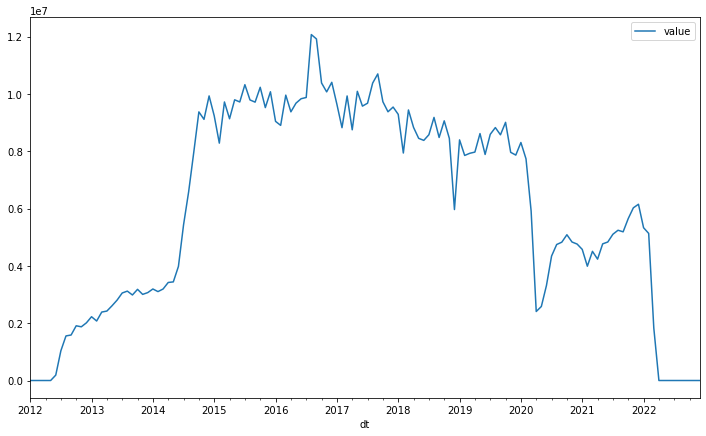

In [213]:
passageiros.groupby('dt').sum().plot(figsize=(12,7))

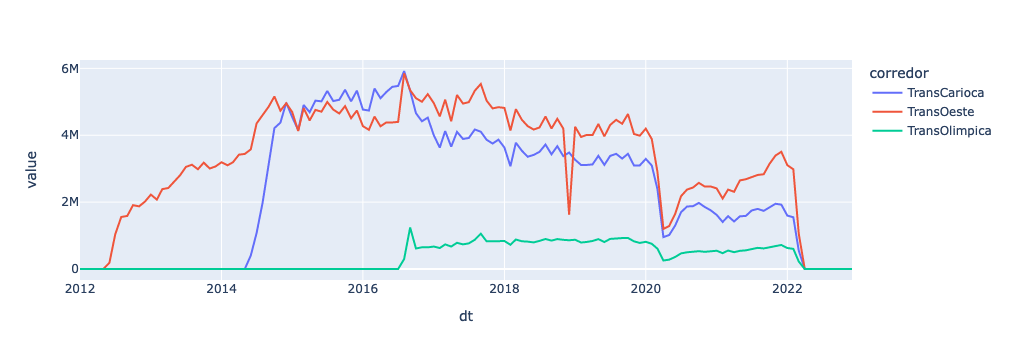

In [224]:
px.line(passageiros.groupby(['dt', 'corredor']).sum().reset_index(), x='dt', y='value', color='corredor', width=720)

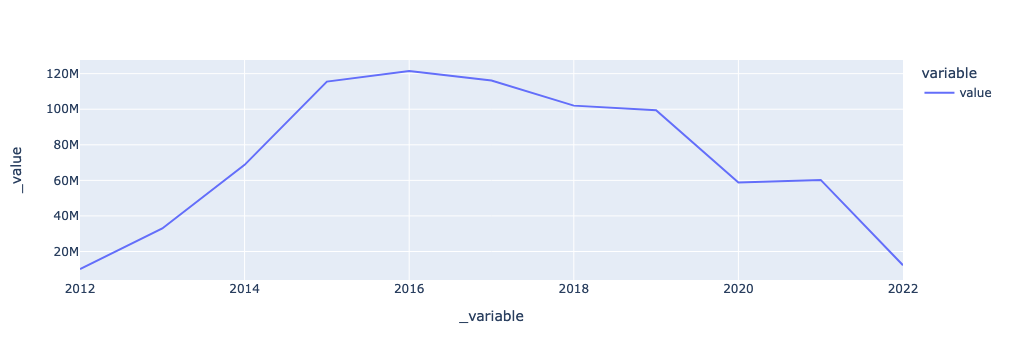

In [231]:
passageiros['variable'] = passageiros['variable'].apply(int)
passageiros.sort_values(by='variable').groupby('variable').sum()

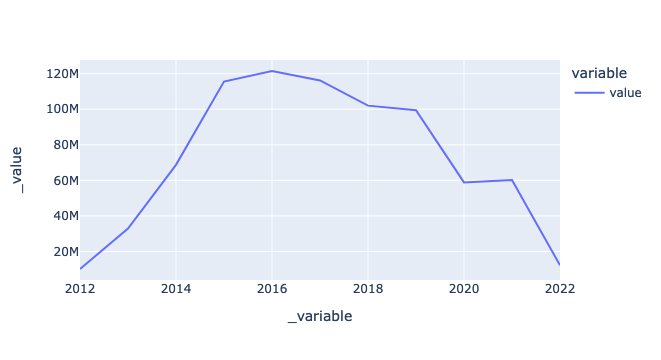

In [308]:
px.line(passageiros.groupby('dt').sum().divide(25).reset_index(), x='dt', y='value',  width=720)

In [314]:
passageiros_mes = passageiros.groupby('dt').sum().divide(25).reset_index()[['dt', 'value']]

In [328]:
passageiros_mes['2012-2016'] = passageiros_mes[passageiros_mes['dt'] <= '2017-01-01']['value']

In [329]:
passageiros_mes['2017-2020'] = passageiros_mes[(passageiros_mes['dt'] >= '2017-01-01') & (passageiros_mes['dt'] <= '2021-01-01')]['value']

In [330]:
passageiros_mes['2021'] = passageiros_mes[passageiros_mes['dt'] >= '2021-01-01']['value']

In [333]:
print(passageiros_mes[['dt','2012-2016', '2017-2020', '2021']].to_csv(index=False))

dt,2012-2016,2017-2020,2021
2012-01-01,0.0,,
2012-02-01,0.0,,
2012-03-01,0.0,,
2012-04-01,0.0,,
2012-05-01,0.0,,
2012-06-01,7520.24,,
2012-07-01,41487.56,,
2012-08-01,62221.16,,
2012-09-01,63475.04,,
2012-10-01,76362.92,,
2012-11-01,74934.24,,
2012-12-01,80508.08,,
2013-01-01,88996.04,,
2013-02-01,83021.8,,
2013-03-01,95533.68,,
2013-04-01,96889.04,,
2013-05-01,104232.32,,
2013-06-01,112192.2,,
2013-07-01,122127.64,,
2013-08-01,124742.24,,
2013-09-01,119352.16,,
2013-10-01,127226.72,,
2013-11-01,120188.16,,
2013-12-01,122679.12,,
2014-01-01,127708.52,,
2014-02-01,124066.16,,
2014-03-01,127710.52,,
2014-04-01,136797.4,,
2014-05-01,137628.32,,
2014-06-01,159216.44,,
2014-07-01,217141.4,,
2014-08-01,263487.04,,
2014-09-01,318461.2,,
2014-10-01,374860.4,,
2014-11-01,364443.64,,
2014-12-01,397142.88,,
2015-01-01,369393.8,,
2015-02-01,331253.04,,
2015-03-01,388709.04,,
2015-04-01,365269.8,,
2015-05-01,391734.08,,
2015-06-01,388726.48,,
2015-07-01,412824.64,,
2015-08-01,391543.76,,
2015-09-01

In [234]:
passageiros_ano = passageiros.sort_values(by='variable').groupby('variable').sum().reset_index().rename(
    columns={'variable':'ano', 'value':'passageiros'}
)

In [237]:
print(passageiros_ano.to_csv(index=False))

ano,passageiros
2012,10162731
2013,32929528
2014,68716598
2015,115522708
2016,121491319
2017,116182658
2018,102020346
2019,99460097
2020,58846565
2021,60257047
2022,12293526



In [235]:
passageiros_ano.to_csv('data/treated/passageiros_ano.csv', index=False)

### Dados

- Numero de estações
    - 2016
    - 2020
    - 2022
    - Futuro
    - Gráfico

In [342]:
len(estacoes_final[estacoes_final['corredor'] == 'TransOeste'])

68

In [345]:
stops_oeste = estacoes_final[estacoes_final['corredor'] == 'TransOeste']['stop_id']

In [348]:
len(estacoes_final[~(estacoes_final['stop_id'].isin(stops_oeste)) & (estacoes_final['corredor'] == 'TransCarioca')])

48

### Dados

- Numero de veículos
    - 2016
    - 2020
    - 2022
    - Futuro
    - Gráfico

In [ ]:
DEZ/2016, 436
DEZ/2020, 120
DEZ/2021, 245
MAR/2022, 254
FUTURO  , 572

### Dados

- Comprimento dos corredores e número de estações por corredor
- Custo/km metro vs BRT

In [1]:
# import requests

# url = "https://maps.googleapis.com/maps/api/directions/json?origin=Toronto&destination=Montreal&avoid=highways&mode=bicycling&key=-Nfeg2M"

# payload={}
# headers = {}

# response = requests.request("GET", url, headers=headers, data=payload)



### Comparação de trajetos utilizando Google Directions API

In [42]:
credential = json.load(open('/Users/m/gabinite_sv/credentials/basedosdados/mac/emd/escritorio-rj-dev/google_directions_api.json'))

In [ ]:
cre

In [35]:
import googlemaps
from datetime import datetime
import json

key = json.loads
gmaps = googlemaps.Client(key= '<put-your-key-here>')

# downtown = (-22.999928,-43.3247031)
# tanque = (-22.9184421,-43.3604)

# directions_result = gmaps.directions(
#     origin = downtown,
#     destination=tanque,
#     mode="transit",
#     departure_time=datetime.now()
# )
# directions_result = directions_result[0]

ValueError: Invalid API key provided.

In [32]:
directions_result.keys()

dict_keys(['bounds', 'copyrights', 'legs', 'overview_polyline', 'summary', 'warnings', 'waypoint_order'])

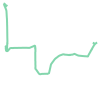

In [34]:
import polyline
from shapely.geometry import LineString

p = directions_result['overview_polyline']['points']
LineString(polyline.decode(p))